In [28]:
import os
import PIL
from PIL import Image
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import itertools
from torchvision import datasets, transforms, models
from custom_transform import ThresholdTransform,AddNoise,DetachWhite
from einops import rearrange

# Image Open

# Model


In [29]:
import torchvision.models as models
model=models.efficientnet_b1(pretrained=True,progress=False)
model.classifier[1] = torch.nn.Linear(1280, 2)
import torchvision
# model=torchvision.models.resnet18()
# in_feat=model.fc.in_features
# model.fc=torch.nn.Linear(in_feat,2)
data_path='/data/datasets/asd/All_5split/01/val/TD/'
# data_path='/data/datasets/ai_hub_sketch_4way/01/val/m_w'
# data_path='/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/w/'
import random
weight='/data/jong980812/project/mae/result_ver2/All_5split/binary_240/OUT/01/checkpoint-29.pth'
checkpoint = torch.load(weight, map_location='cpu')
print("Load pre-trained checkpoint from: %s" % weight)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
model.eval()
print(msg)

Load pre-trained checkpoint from: /data/jong980812/project/mae/result_ver2/All_5split/binary_240/OUT/01/checkpoint-29.pth
<All keys matched successfully>


In [30]:
# 'label': '사람전체', 'x': 571, 'y': 275, 'w': 268, 'h': 635},
#    {'label': '머리', 'x': 590, 'y': 278, 'w': 172, 'h': 153},
#    {'label': '얼굴', 'x': 592, 'y': 329, 'w': 168, 'h': 103},
#    {'label': '눈', 'x': 622, 'y': 351, 'w': 34, 'h': 25},
#    {'label': '눈', 'x': 677, 'y': 344, 'w': 39, 'h': 24},
#    {'label': '코', 'x': 663, 'y': 354, 'w': 11, 'h': 26},
#    {'label': '입', 'x': 661, 'y': 384, 'w': 26, 'h': 13},
#    {'label': '귀', 'x': 592, 'y': 362, 'w': 25, 'h': 26},
#    {'label': '귀', 'x': 732, 'y': 350, 'w': 26, 'h': 26},
#    {'label': '머리카락', 'x': 602, 'y': 280, 'w': 144, 'h': 62},
#    {'label': '목', 'x': 668, 'y': 423, 'w': 35, 'h': 25},
#    {'label': '상체', 'x': 639, 'y': 424, 'w': 139, 'h': 180},
#    {'label': '팔', 'x': 579, 'y': 450, 'w': 65, 'h': 202},
#    {'label': '팔', 'x': 757, 'y': 429, 'w': 74, 'h': 175},
#    {'label': '손', 'x': 588, 'y': 607, 'w': 56, 'h': 48},
#    {'label': '손', 'x': 771, 'y': 553, 'w': 60, 'h': 54},
#    {'label': '다리', 'x': 728, 'y': 577, 'w': 105, 'h': 323},
#    {'label': '다리', 'x': 644, 'y': 588, 'w': 119, 'h': 326},
#    {'label': '발', 'x': 691, 'y': 847, 'w': 70, 'h': 67},
#    {'label': '발', 'x': 761, 'y': 833, 'w': 74, 'h': 67},
#    {'label': '단추', 'x': 669, 'y': 455, 'w': 51, 'h': 121},
#    {'label': '주머니', 'x': 646, 'y': 590, 'w': 50, 'h': 64},
#    {'label': '주머니', 'x': 732, 'y': 576, 'w': 57, 'h': 53},
#    {'label': '운동화', 'x': 604, 'y': 914, 'w': 79, 'h': 117},
#    {'label': '운동화', 'x': 679, 'y': 920, 'w': 74, 'h': 106},
#    {'label': '남자구두', 'x': 888, 'y': 752, 'w': 111, 'h': 86},
#    {'label': '남자구두', 'x': 910, 'y': 816, 'w': 131, 'h': 88}]},
part = {
    '사람전체':'human_body',
    '머리':'head',
    '얼굴':'face',
    '눈':'eye',
    '코':'nose',
    '입':'mouth',
    '귀':'ear',
    '머리카락':'hair',
    '목':'neck',
    '상체':'upper_body_else_arm',
    '팔':'arm',
    '손':'hand',
    '다리':'leg',
    '발':'foot',
    '단추':'button',
    '주머니':'pocket',
    '운동화':'sneakers',
    '남자구두':'man_shoes',
    '여자구두':'woman_shoes'
    
}

# Json Open

# Make ai_hub json to asd_style

In [31]:
# from tqdm import tqdm
# json_path_list =  os.listdir('/data/datasets/ai_hub_sketch_json')
# target_folder = ''
# for json_path in tqdm(json_path_list):
#     original_json_path=os.path.join('/data/datasets/ai_hub_sketch_json/',json_path)
#     with open(original_json_path, 'r') as f:
#         boxes = json.load(f)['annotations']['bbox']
        
#         empty_json = {
#         "version":"0",
#         "flags":{},
#         "developer":"jongseo",
#         "shapes":[
            
#         ]}
#         for box in boxes:
#             korean_part=box['label']
#             box['label']=part[korean_part]
#             # print(box)
#             new_dict = {}
#             x =  box['x']
#             y =  box['y']
#             h =  box['h']
#             w =  box['w']
#             xmin, ymin = int(x), int(y)
#             xmax, ymax = int(x + w), int(y + h)
#             new_dict["label"] = box['label']
#             new_dict["points"]=[]
#             new_dict["points"].append([xmin,ymin])
#             new_dict["points"].append([xmax,ymax])
#             empty_json["shapes"].append(new_dict)
#     json_data = json.dumps(empty_json, indent=4)  # indent 매개변수는 JSON을 읽기 쉽게 들여쓰기를 추가합니다.
#     print(x,y,h,w,xmin,ymin,xmax,ymax);break
#     # # JSON 데이터를 파일에 저장
#     # with open(os.path.join("/data/datasets/ai_hub_sketch_json_asd_version",json_path), "w") as json_file:
#     #     json_file.write(json_data)
            


        
    


In [32]:
# from tqdm import tqdm
# json_path_list =  os.listdir('/data/datasets/ai_hub_sketch_json')
# target_folder = ''
# for json_path in tqdm(json_path_list):
#     print(json_path);break

In [33]:
class shapley_part(Dataset):
    def __init__(self, data_folder, json_folder, binary_thresholding=None, transform=None):
        self.json_folder = json_folder
        self.data_folder = data_folder
        self.binary_thresholding=binary_thresholding
        self.transform = transform
        self.image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        self.json_paths = [image_path.split('/')[-1].split('.')[0] + ".json" for image_path in self.image_paths] #! Get json path from image paths.
        print(self.image_paths)
    def get_part_json(self, json_file_path):
        '''
        Get part dictionary from json path
        '''
        part_json = {}
        with open(json_file_path, 'r') as f:
            boxes = json.load(f)['shapes']
            for box in boxes:
                part_json[box["label"]]=[]
            for box in boxes:
                part_json[box["label"]].append(box["points"])
    
        for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
            if not part_json[key]:
                part_json[key] = None

        return part_json
    def get_coords(self, part):
        extracted_coordinates = []
        if part is None:
            return None
        elif len(part) == 1:
            # print(part[0][0])
            xmin, ymin = list(map(int,part[0][0]))
            xmax, ymax = list(map(int,part[0][1]))
            return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
        elif len(part) == 2:
            #! Eye, Ear, hand, foot -> These have 2 part, return list
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
        else:
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
        return extracted_coordinates
    def get_white_image(self,size):
        return Image.new("RGB", size, (255, 255, 255))
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        empty_face is face detached  'eye','nose','mouth','ear' from head+hair
        '''
        head_coords = self.get_coords(part_json['head'])
        head = part_imgs['head'][0]#!
        
        hair_coords = self.get_coords(part_json['hair'])
        hair = part_imgs['hair'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])
        white_image.paste(hair,hair_coords[0])
        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
              part_coords= self.get_coords(part_json[part])
              part_img = part_imgs[part]
              if part in ['eye','ear']:   
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
              else:
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
        # white_image.show()
        xmins = [head_coords[0][0],hair_coords[0][0]]
        ymins = [head_coords[0][1],hair_coords[0][1]]
        xmaxs = [head_coords[0][2],hair_coords[0][2]]
        ymaxs = [head_coords[0][3],hair_coords[0][3]]
        empty_face_coords = [min(xmins),min(ymins), max(xmaxs), max(ymaxs)]
        return white_image.crop(empty_face_coords), [[min(xmins),min(ymins)],[max(xmaxs),max(ymaxs)]]
    def get_empty_upper_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        upper body를 목 포함한 걸로 규정하고, 
        1. 백지에 몸통 붙이기
        2. 양 팔 붙이고 손떼기
        3. 목 붙이기
        4. 새로운 upperbody 좌표 규정.
        '''
        upper_body_else_arm_json = part_json['upper_body_else_arm']
        upper_body_else_arm_coords = self.get_coords(upper_body_else_arm_json)
        upper_body_else_arm = part_imgs['upper_body_else_arm'][0]#!
        
        neck_json = part_json['neck']
        neck_coords = self.get_coords(neck_json)
        neck = part_imgs['neck'][0]#!
        
        arm_json = part_json['arm']
        arm_coords = self.get_coords(arm_json)
        left_arm = part_imgs['arm'][0]#!
        right_arm = part_imgs['arm'][1]#!
        
        # hand_json = part_json['hand']
        # hand_coords = self.get_coords(hand_json)
        # left_hand = part_imgs['hand'][0]#!
        # right_hand = part_imgs['hand'][1]#!
        
        white_image = Image.new("RGB", img.size, (255, 255, 255))
        white_image.paste(upper_body_else_arm,upper_body_else_arm_coords[0])
        white_image.paste(neck,neck_coords[0])
        white_image.paste(left_arm,arm_coords[0])
        white_image.paste(right_arm,arm_coords[1])        
        # white_image.paste(left_hand,hand_coords[0])
        # white_image.paste(right_hand,hand_coords[1])
        if part_json["hand"] is not None:
            part_coords= self.get_coords(part_json["hand"])
            part_img = part_imgs["hand"] 
            white_image.paste(Image.new("RGB", part_img[0].size, (255, 255, 255)),part_coords[0])
            white_image.paste(Image.new("RGB", part_img[1].size, (255, 255, 255)),part_coords[1])
        xmins = [arm_coords[0][0],arm_coords[1][0]]#,hand_coords[0][0],hand_coords[1][0]]
        ymins = [arm_coords[0][1],arm_coords[1][1],neck_coords[0][1]]#,hand_coords[0][1],hand_coords[1][1],neck_coords[0][1]]
        xmaxs = [arm_coords[0][2],arm_coords[1][2]]#,hand_coords[0][2],hand_coords[1][2]]
        ymaxs = [upper_body_else_arm_coords[0][3]]#,hand_coords[0][3],hand_coords[1][3]]
        upper_body_coords = [min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
        
        return white_image.crop(upper_body_coords), [[upper_body_coords[0],upper_body_coords[1]],[upper_body_coords[2],upper_body_coords[3]]]

    def get_empty_lower_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        leg 두개를 빈 도화지에 붙이고 발을 뗀뒤 empty lower body로 규정.
        '''
        white_image = self.get_white_image(img.size)
        
        leg_json = part_json['leg']
        leg_coords = self.get_coords(leg_json)
        left_leg = part_imgs['leg'][0]#!
        right_leg = part_imgs['leg'][1]#! l
        
        pocket_json =  part_json['pocket']
        pocket_coords = self.get_coords(pocket_json)
        

        white_image.paste(left_leg,leg_coords[0])
        white_image.paste(right_leg,leg_coords[1])
        for i,pocket in enumerate(part_imgs['pocket']):
            # pocket.show()
            white_image.paste(pocket,pocket_coords[i])
        # white_image.show()
        if part_json["foot"] is not None:
            part_coords= self.get_coords(part_json["foot"])
            part_img = part_imgs["foot"] 
            white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
        # white_image.show()
        # white_image.crop(upper_body_coords[0]).show()
        upper_body_ymax= self.get_coords(part_json["upper_body_else_arm"])[0][3] 
        pocket_ymin = min([pocket_coords[i][1] for i in range(len(part_imgs['pocket']))])
        leg_ymin = min(leg_coords[0][1],leg_coords[1][1])
        xmins = [leg_coords[0][0],leg_coords[1][0]]
        # ymins = [pocket_ymin] if (upper_body_ymax<=pocket_ymin) and (leg_ymin>=pocket_ymin) else [leg_coords[0][1],leg_coords[1][1]]
        ymins = [leg_coords[0][1],leg_coords[1][1]]
        xmaxs = [leg_coords[0][2],leg_coords[1][2]]
        ymaxs = [leg_coords[0][3],leg_coords[1][3]]
        lower_body_coords = [min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
        # white_image.crop(lower_body_coords).show()
        return white_image.crop(lower_body_coords),[[min(xmins),min(ymins)],[max(xmaxs),max(ymaxs)]]
    
    def create_new_images(self,img, binary_combination, part_imgs,part_json,label):
        #! Making New images
        original_img = img
        empty_face_active, eye_active, nose_active, ear_active, mouth_active, hand_active, foot_active = binary_combination
        # new_image = self.get_white_image(original_img.size)
        new_image = img.copy()
        # new_image.paste(self.get_white_image(part_imgs['empty_face'][0].size,self.get_coords(part_json['empty_face']))
        for i in range(len(part_imgs['empty_face'])):
            new_image.paste(self.get_white_image(part_imgs['empty_face'][i].size),self.get_coords(part_json['empty_face'])[i])
        for i in range(len(part_imgs['eye'])):
            new_image.paste(self.get_white_image(part_imgs['eye'][i].size),self.get_coords(part_json['eye'])[i])
        for i in range(len(part_imgs['nose'])):
            new_image.paste(self.get_white_image(part_imgs['nose'][i].size),self.get_coords(part_json['nose'])[i])
        for i in range(len(part_imgs['ear'])):
            new_image.paste(self.get_white_image(part_imgs['ear'][i].size),self.get_coords(part_json['ear'])[i])
        for i in range(len(part_imgs['mouth'])):
            new_image.paste(self.get_white_image(part_imgs['mouth'][i].size),self.get_coords(part_json['mouth'])[i])
        for i in range(len(part_imgs['hand'])):
            new_image.paste(self.get_white_image(part_imgs['hand'][i].size),self.get_coords(part_json['hand'])[i])
        for i in range(len(part_imgs['foot'])):
            new_image.paste(self.get_white_image(part_imgs['foot'][i].size),self.get_coords(part_json['foot'])[i]) 
        if part_json['sneakers'] is not None:
            # print(part_json['sneakers'])
            for i in range(len(part_json['sneakers'])):
                new_image.paste(self.get_white_image(part_imgs['sneakers'][i].size),self.get_coords(part_json['sneakers'])[i])
        if label == 0 and (part_json['man_shoes'] is not None):
            for i in range(len(part_json['man_shoes'])):
                new_image.paste(self.get_white_image(part_imgs['man_shoes'][i].size),self.get_coords(part_json['man_shoes'])[i])
        elif label == 1 and (part_json['woman_shoes'] is not None):
            for i in range(len(part_json['woman_shoes'])):
                new_image.paste(self.get_white_image(part_imgs['woman_shoes'][i].size),self.get_coords(part_json['woman_shoes'])[i])
        
        new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['empty_upper_body'])[0])  # 원하는 위치에 붙임
        
        if empty_face_active:
            new_image.paste(part_imgs["empty_face"][0],self.get_coords(part_json['empty_face'])[0])
        # print(part_json['lower_body'][0])
        # print(part_imgs["empty_lower_body"][0].size,self.get_coords(part_json['lower_body'])[0] )
        # new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['empty_upper_body'])[0])  # 원하는 위치에 붙임
        # new_image.paste(part_imgs["empty_lower_body"][0], self.get_coords(part_json['empty_lower_body'])[0])  # 원하는 위치에 붙임
        # pocket_coords = self.get_coords(part_json['pocket'])
        # for i,pocket in enumerate(part_imgs['pocket']):
        # #     # pocket.show()
        #     new_image.paste(pocket,pocket_coords[i])
        # 각 파트 이미지를 읽어와서 새로운 이미지에 붙임
        if eye_active and (part_json["eye"] is not None):
            new_image.paste(part_imgs["eye"][0], self.get_coords(part_json['eye'])[0])  # 원하는 위치에 붙임
            new_image.paste(part_imgs["eye"][1], self.get_coords(part_json['eye'])[1])  # 원하는 위치에 붙임 
        if nose_active and (part_json["nose"] is not None):
            new_image.paste(part_imgs["nose"][0], self.get_coords(part_json['nose'])[0])  # 원하는 위치에 붙임 
        if ear_active and (part_json["ear"] is not None):
            new_image.paste(part_imgs["ear"][0], self.get_coords(part_json['ear'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["ear"][1], self.get_coords(part_json['ear'])[1])  # 원하는 위치에 붙임 
        if mouth_active and (part_json["mouth"] is not None):
            new_image.paste(part_imgs["mouth"][0], self.get_coords(part_json['mouth'])[0])  # 원하는 위치에 붙임 
        if hand_active and (part_json["hand"] is not None):
            new_image.paste(part_imgs["hand"][0], self.get_coords(part_json['hand'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["hand"][1], self.get_coords(part_json['hand'])[1])  # 원하는 위치에 붙임 
        if foot_active and (part_json["foot"] is not None):
            new_image.paste(part_imgs["foot"][0], self.get_coords(part_json['foot'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["foot"][1], self.get_coords(part_json['foot'])[1])  # 원하는 위치에 붙임 
        # 다른 파트들에 대해서도 같은 방식으로 처리
        return new_image.crop( self.get_coords(part_json['human_body'])[0])
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        print(img_path)
        label = 0 if (img_path.split('/')[-1].split('.')[0].split('_')[0])=='m' else 1
        image = Image.open(img_path)
        part_name = ["human_body","face","head","hair", "neck","eye", "nose", "ear", "mouth","pocket","arm","hand", "leg","foot", "sneakers","upper_body_else_arm"]#원하는 파트
        part_name.append('man_shoes') if label==0 else part_name.append('woman_shoes')
        if self.binary_thresholding:
            image = image.convert("L")#! Convert grayscale
            image = image.point(lambda p: p > self.binary_thresholding and 255)
        part_json = self.get_part_json(os.path.join(self.json_folder,self.json_paths[idx]))#! 존재하는 모든 part에 대해서 불러옴.
        part_imgs = {}
        for part in part_name:#모든 part를 잘라서 다시 dict으로 리턴하기위함.
            part_imgs[part]=[]
            coords = self.get_coords(part_json[part])
            # print(part_json)
            if coords is None:
                part_imgs[part].append(None)    
            # elif len(coords) ==1:
            #     part_imgs[part].append(image.crop(coords[0]))    
            # elif len(coords) == 2:
            else:
                for i in range(len(coords)):
                    part_imgs[part].append(image.crop(coords[i]))    
        empty_face , empty_face_coords= self.get_empty_face(image,part_imgs,part_json)
        # empty_face.show()
        empty_upper_body, empty_upper_body_coords = self.get_empty_upper_body(image,part_imgs,part_json)
        empty_lower_body, empty_lower_body_coords= self.get_empty_lower_body(image,part_imgs,part_json)
        
        part_imgs['empty_face']=[empty_face]
        part_json['empty_face']=[empty_face_coords]
        part_imgs['empty_lower_body']=[empty_lower_body]
        part_json['empty_lower_body']=[empty_lower_body_coords]
        part_imgs['empty_upper_body']=[empty_upper_body]
        part_json['empty_upper_body']=[empty_upper_body_coords]#좌표 바뀌어서 넣어줘야함.
        part_combinations = list(itertools.product([0, 1], repeat=7))
        new_imgs = []
        # print(part_json)
        for combination in part_combinations:
            # print(combination)
            new_img=self.create_new_images(img=image,binary_combination=combination, part_imgs=part_imgs,part_json=part_json,label=label)
            if self.transform:
                new_img=self.transform(new_img).expand(3,-1,-1)
            new_imgs.append(new_img.unsqueeze(0))
        new_imgs = torch.cat(new_imgs,dim=0)
        image = self.transform(image)
        image_3ch = image.expand(3,-1,-1)
        return new_imgs,image_3ch,label 

In [34]:
data=shapley_part('/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/', '/data/datasets/ai_hub_sketch_json_asd_version/',240,transforms.Compose([transforms.Resize([224,168]),transforms.ToTensor()]))
# data[0][0].show()

['/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_11_m_02590.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_13_m_12773.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_13_w_02871.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_m_10261.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_w_09309.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_10_w_06799.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_8_m_11546.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_11_w_06321.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_m_10094.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_10_w_05644.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_w_09441.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_m_06842.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_m_03145.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_8_w_06025.jpg', '/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/

In [35]:
img=Image.open('/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_11_w_06321.jpg')
# img.crop( [526, 801, 810, 1226])
#[[[504, 419], [651, 697]]],
# 'arm': [[[421, 437], [523, 694]], [[646, 420], [726, 672]]],
#  'hand': [[[646, 621], [726, 672]], [[440, 645], [523, 694]]],
#  'leg': [[[493, 685], [590, 989]], [[577, 685], [643, 979]]],

/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_m_06842.jpg


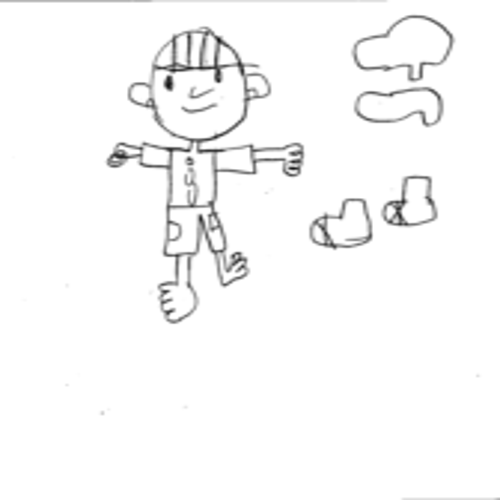

/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/m/m_12_m_06842.jpg


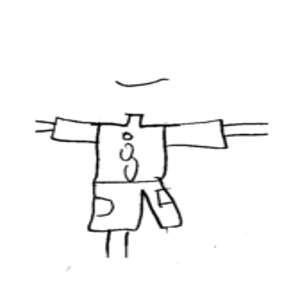

In [74]:
topil=transforms.ToPILImage()
topil(data[11][1]).resize((500,500)).show()
topil(data[11][0][4]).resize((300,300)).show()

In [ ]:
topil=transforms.ToPILImage()
num=1
for i in range(100):
    # topil(data[i][0][0]).resize((224,224)).show()
    # topil(data[i][1]).resize((224,224)).show()
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(topil(data[i][0][0]).resize((224,224)))
    axes[0].set_title('Image 1')

    axes[1].imshow(topil(data[i][1]).resize((224,224)))
    axes[1].set_title('Image 2')

    # 불필요한 축 숨기기
    for ax in axes:
        ax.axis('off')

    plt.show()


In [ ]:
a=topil(data[num][1]).resize((500,500))
b=a.copy()
b=b.resize((224,224))
a.show()
b.show()


In [ ]:

'''
Get part dictionary from json path
'''
part_json = {}
with open('/data/datasets/ai_hub_sketch_json_asd_version/w_12_m_00681.json', 'r') as f:
    boxes = json.load(f)['shapes']
    for box in boxes:
        part_json[box["label"]]=[]
    for box in boxes:
        part_json[box["label"]].append(box["points"])

for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
    if not part_json[key]:
        part_json[key] = None



In [ ]:
def get_white_image(size):
    return Image.new("RGB", size, (255, 255, 255))
def get_coords( part):
    extracted_coordinates = []
    if part is None:
        return None
    elif len(part) == 1:
        # print(part[0][0])
        xmin, ymin = list(map(int,part[0][0]))
        xmax, ymax = list(map(int,part[0][1]))
        return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
    elif len(part) == 2:
        #! Eye, Ear, hand, foot -> These have 2 part, return list
        for a in part: 
            # print(a)
            xmin, ymin = list(map(int,a[0]))
            xmax, ymax = list(map(int,a[1]))
            extracted_coordinates.append([xmin,ymin,xmax,ymax])
        return extracted_coordinates
    else:
        exit(0)
def get_empty_upper_body(img, part_imgs, part_json):
    '''
    empty_lower_body detacched foot
    upper body를 목 포함한 걸로 규정하고, 
    1. 백지에 몸통 붙이기
    2. 양 팔 붙이고 손떼기
    3. 목 붙이기
    4. 새로운 upperbody 좌표 규정.
    '''
    upper_body_else_arm_json = part_json['upper_body_else_arm']
    upper_body_else_arm_coords = get_coords(upper_body_else_arm_json)
    upper_body_else_arm = part_imgs['upper_body_else_arm'][0]#!
    
    neck_json = part_json['neck']
    neck_coords = get_coords(neck_json)
    neck = part_imgs['neck'][0]#!
    
    arm_json = part_json['arm']
    arm_coords = get_coords(arm_json)
    left_arm = part_imgs['arm'][0]#!
    right_arm = part_imgs['arm'][1]#!
    
    # hand_json = part_json['hand']
    # hand_coords = get_coords(hand_json)
    # left_hand = part_imgs['hand'][0]#!
    # right_hand = part_imgs['hand'][1]#!
    
    white_image = Image.new("RGB", img.size, (255, 255, 255))
    white_image.paste(upper_body_else_arm,upper_body_else_arm_coords[0])
    white_image.paste(neck,neck_coords[0])
    white_image.paste(left_arm,arm_coords[0])
    white_image.paste(right_arm,arm_coords[1])        
    # white_image.paste(left_hand,hand_coords[0])
    # white_image.paste(right_hand,hand_coords[1])
    if part_json["hand"] is not None:
        part_coords= get_coords(part_json["hand"])
        part_img = part_imgs["hand"] 
        white_image.paste(Image.new("RGB", part_img[0].size, (255, 255, 255)),part_coords[0])
        white_image.paste(Image.new("RGB", part_img[1].size, (255, 255, 255)),part_coords[1])
    xmins = [arm_coords[0][0],arm_coords[1][0]]#,hand_coords[0][0],hand_coords[1][0]]
    ymins = [arm_coords[0][1],arm_coords[1][1],neck_coords[0][1]]#,hand_coords[0][1],hand_coords[1][1],neck_coords[0][1]]
    xmaxs = [arm_coords[0][2],arm_coords[1][2]]#,hand_coords[0][2],hand_coords[1][2]]
    ymaxs = [arm_coords[0][3],arm_coords[1][3]]#,hand_coords[0][3],hand_coords[1][3]]
    upper_body_coords = [min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
    
    return white_image.crop(upper_body_coords), [[upper_body_coords[0],upper_body_coords[1]],[upper_body_coords[2],upper_body_coords[3]]]
def get_empty_lower_body(img, part_imgs, part_json):
    '''
    empty_lower_body detacched foot
    leg 두개를 빈 도화지에 붙이고 발을 뗀뒤 empty lower body로 규정.
    '''
    leg_json = part_json['leg']
    leg_coords = get_coords(leg_json)
    left_leg = part_imgs['leg'][0]#!
    right_leg = part_imgs['leg'][1]#! l
    
    white_image = get_white_image(img.size)
    white_image.paste(left_leg,leg_coords[0])
    white_image.paste(right_leg,leg_coords[1])
    
    if part_json["foot"] is not None:
        part_coords= get_coords(part_json["foot"])
        part_img = part_imgs["foot"] 
        white_image.paste(get_white_image(part_img[0].size),part_coords[0])
        white_image.paste(get_white_image(part_img[1].size),part_coords[1])
    # white_image.crop(upper_body_coords[0]).show()
    xmins = [leg_coords[0][0],leg_coords[1][0]]
    ymins = [leg_coords[0][1],leg_coords[1][1]]
    xmaxs = [leg_coords[0][2],leg_coords[1][2]]
    ymaxs = [leg_coords[0][3],leg_coords[1][3]]
    lower_body_coords = [min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
    return white_image.crop(lower_body_coords),[min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
def get_empty_face(img, part_imgs, part_json):
    '''
    empty_face is face detached  'eye','nose','mouth','ear' from head+hair
    '''
    head_coords = get_coords(part_json['head'])
    head = part_imgs['head'][0]#!
    
    hair_coords = get_coords(part_json['hair'])
    hair = part_imgs['hair'][0]#!
    white_image = get_white_image(img.size)
    white_image.paste(head,head_coords[0])
    white_image.paste(hair,hair_coords[0])
    for part in ['eye','nose','mouth','ear']:
        if part_json[part] is not None:
            part_coords= get_coords(part_json[part])
            part_img = part_imgs[part]
            if part in ['eye','ear']:   
                white_image.paste(get_white_image(part_img[0].size),part_coords[0])
                white_image.paste(get_white_image(part_img[1].size),part_coords[1])
            else:
                white_image.paste(get_white_image(part_img[0].size),part_coords[0])
    # white_image.show()
    xmins = [head_coords[0][0],hair_coords[0][0]]
    ymins = [head_coords[0][1],hair_coords[0][1]]
    xmaxs = [head_coords[0][2],hair_coords[0][2]]
    ymaxs = [head_coords[0][3],hair_coords[0][3]]
    
    return white_image, [[min(xmins),min(ymins),max(xmaxs),max(ymaxs)]]

In [ ]:
part_name = ["human_body","hair","face","head", "neck","eye", "nose", "ear", "mouth","arm","hand", "leg","foot", "upper_body_else_arm"]#원하는 파트
part_imgs={}
for part in part_name:#모든 part를 잘라서 다시 dict으로 리턴하기위함.
    part_imgs[part]=[]
    # print(part)
    coords = get_coords(part_json[part])
    # print(coords)
    if coords is None:
        part_imgs[part].append(None)    
        
    elif len(coords) ==1:
        part_imgs[part].append(img.crop(coords[0]))    
    elif len(coords) == 2:
        part_imgs[part].append(img.crop(coords[0]))    
        part_imgs[part].append(img.crop(coords[1]))    

In [ ]:
get_empty_upper_body(img,part_imgs,part_json)[0].show()
get_empty_lower_body(img,part_imgs,part_json)[0].show()
get_empty_face(img,part_imgs,part_json)[0].show()

In [ ]:
Image.open('/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/w/w_10_m_00389.jpg').size

In [ ]:
part_json